## Import Libraries

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as trns
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 10]

/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torchvision/image.so'
  Expected in: '/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


## Load dataset

In [2]:
# List available images
# ls '../datasets/nih-chest-xray/images'

In [3]:
data_path = '../datasets/nih-chest-xray/images'

In [4]:
images_list = dict()
for f in os.listdir(data_path):
    if os.path.isfile(os.path.join(data_path, f)) and f[-4:] == '.png':
        images_list[f] = os.path.join(data_path, f)

In [5]:
# List full paths
# images_list

In [6]:
df = pd.read_csv('../datasets/nih-chest-xray/sample_labels.csv')
print(len(df))

# Sample df for smaller sample
# df = df.sample(frac=0.01, replace=False, random_state=1)

df.head(10)

5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


In [7]:
def plotImage(img):
    plt.imshow(np.array(img) / 255)
    
def openImage(str_path):
    return Image.open(str_path).convert('RGB')

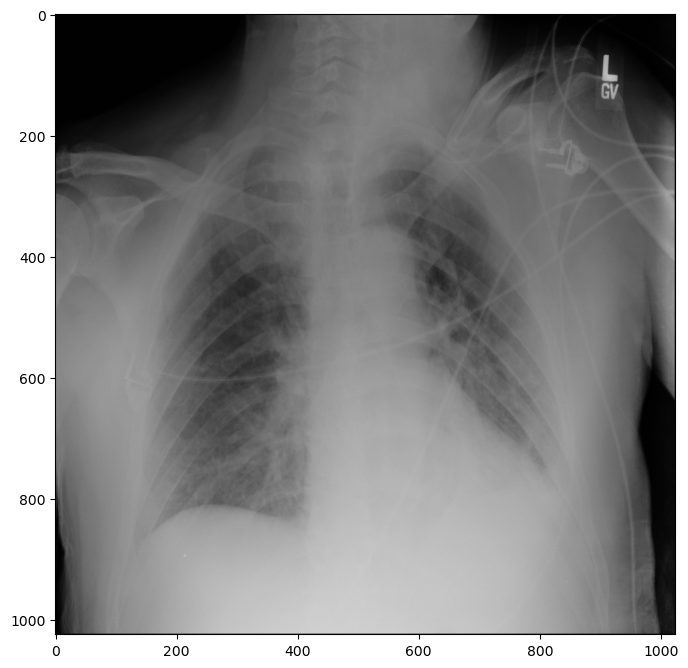

In [8]:
plotImage(openImage(images_list[list(images_list.keys())[1]]))

## Recode classes

In [9]:
classes = [
    'Atelectasis', 
    'Consolidation', 
    'Infiltration', 
    'Pneumothorax', 
    'Edema', 
    'Emphysema', 
    'Fibrosis', 
    'Effusion', 
    'Pneumonia', 
    'Pleural_thickening', 
    'Cardiomegaly', 
    'Nodule', 
    'Mass', 
    'Hernia', 
    'No Finding']

In [10]:
df['Finding Labels'].value_counts().to_frame()

,Finding Labels
No Finding,3044
Infiltration,503
Effusion,203
Atelectasis,192
Nodule,144
...,...
Atelectasis|Edema|Effusion|Infiltration|Pneumonia,1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia,1
Atelectasis|Effusion|Hernia,1
Atelectasis|Hernia|Pneumothorax,1


In [11]:
recode_classes = ['Pneumonia', 'No Finding', 'Other']

## Create DataLoader

In [12]:
class DataLoaderCompose(Dataset):
    def __init__(self, data, transforms):
        self.image_paths = [images_list[f] for f in data[0]]
        self.labels = data[1]
        self.transforms = transforms
        
    def __len__(self):
        return len(data[0])
    
    def __getitem__(self, idx):
        image = self.transforms(openImage(self.image_paths[idx]))
        target = torch.tensor([int(cls in self.labels[idx]) for cls in recode_classes], dtype=torch.float32)
        return (image, target)

In [13]:
data_limit = 5000 
data = (df.iloc[:data_limit, 0], [[(x if 'Pneumonia' in x or 'No Finding' in x else 'Other') for x in df.iloc[i, 1].split('|')] for i in range(data_limit)])
#data = (df.iloc[:5000, 0], [df.iloc[i, 1].split('|') for i in range(5000)])

In [14]:
# Ensure proper classes
data[1][0:5]

[['Other', 'Other', 'Other', 'Other'],
 ['Other', 'Other'],
 ['No Finding'],
 ['Other'],
 ['Other', 'Other', 'Other']]

In [15]:
len(data[0])

5000

In [16]:
dataset = DataLoaderCompose(data, trns.Compose([
    trns.Resize((240, 240)),
    trns.ToTensor(), 
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],inplace=True)
]))

In [17]:
print(dataset[1][1])

tensor([0., 0., 1.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


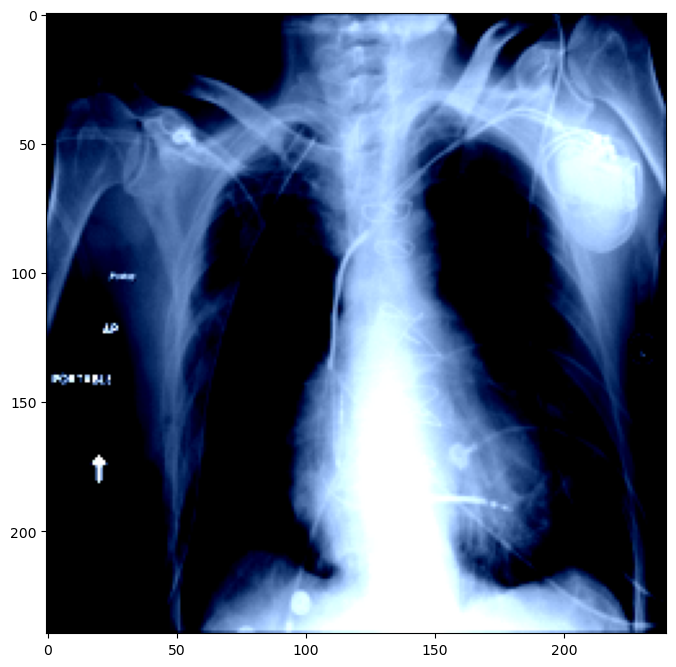

In [18]:
plt.imshow(dataset[1][0].permute((1, 2, 0)))

## Train and test split 80/20

In [19]:
train_dataset, validation_dataset = random_split(dataset, [int(len(dataset) * 0.80), len(dataset) - int(len(dataset) * 0.80)])

In [20]:
train_dataset_size = len(train_dataset)
validation_dataset_size = len(validation_dataset)
train_dataset_size, validation_dataset_size

(4000, 1000)

# Benchmark Experiment

### Define base pretrained model

In [21]:
resnet34 = models.resnet34(pretrained=True)
resnet34

/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/navya/miniforge3/envs/MM/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Constants for all models

In [22]:
num_classes = 3
input_shape = (3, 240, 240)

batch_size = 64
learning_rate = 1e-1

epochs_per_client = 3 #5 #If not federated learning model, just epoch number for single client
opt_func = torch.optim.Adam

### DataLoader functions

In [23]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [24]:
print(f'Device detected is {device}')

Device detected is cpu


### Model classes

In [25]:
class SimpleFederatedNetwork(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.fc = torch.nn.Linear(self.network.fc.in_features, num_classes)
        self.track_layers = {
            'layer4':  self.network.layer4,
            'linear': self.network.fc
        }
        self.freeze()

    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for layer_name in self.track_layers:
            for param in self.track_layers[layer_name].parameters():
                param.requires_grad = True
    
    def forward(self, x_batch):
        out = torch.sigmoid(self.network(x_batch))
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                layer_params = list(self.track_layers[layer_name].parameters())
                for i in range(len(layer_params)):
                    layer_params[i].data = (layer_params[i].data + (parameters_dict[layer_name][i] - 
                                                layer_params[i].data))
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = [param.data.clone().detach() for param in self.track_layers
                                                [layer_name].parameters()]
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            return torch.tensor(torch.sum((outputs > 0.5) == labels).item() / len(outputs))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.binary_cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        self.train()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=64):
        self.eval()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [26]:
class VanillaPyTorchNetwork(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.fc = torch.nn.Linear(self.network.fc.in_features, num_classes)
        self.track_layers = {
            'layer4':  self.network.layer4,
            'linear': self.network.fc
        }
        self.freeze()

    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for layer_name in self.track_layers:
            for param in self.track_layers[layer_name].parameters():
                param.requires_grad = True
    
    def forward(self, x_batch):
        out = torch.sigmoid(self.network(x_batch))
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                layer_params = list(self.track_layers[layer_name].parameters())
                for i in range(len(layer_params)):
                    layer_params[i].data = (layer_params[i].data + (parameters_dict[layer_name][i] - 
                                                layer_params[i].data))
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = [param.data.clone().detach() for param in self.track_layers
                                                [layer_name].parameters()]
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            return torch.tensor(torch.sum((outputs > 0.5) == labels).item() / len(outputs))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.binary_cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        self.train()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=64):
        self.eval()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [27]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict, return_model_dict=False):
        net = to_device(SimpleFederatedNetwork(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print(self.client_id + ':')
        for i, res in enumerate(train_history):
            print('Epoch [{}]: Loss = {}, Accuracy = {}'.format(i + 1, round(res[0], 4), round(res[1], 4)))
        return net.get_parameters(), net.state_dict() if return_model_dict else None

## Benchmark 1: Vanilla PyTorch model

In [ ]:
# Constants
num_clients = 1
rounds = 1

example = train_dataset_size 
length = [min(i + example, train_dataset_size) - i for i in range(0, train_dataset_size, example)]
print(length)

client_datasets = random_split(train_dataset, length)
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]
print(clients)

# Instantiate pt network
pt = to_device(VanillaPyTorchNetwork(), device)

# Train network
history_loss = []
history_acc = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    i_parameters = pt.get_parameters()
    i_1_parameters = dict([(layer_name, [0 for param in pt.track_layers[layer_name].parameters()]) for layer_name in i_parameters])
    
    # Single round per single client 
    for j, client in enumerate(clients):
        client_parameters, state_dict = client.train(i_parameters, (j == len(clients) - 1))
        
        pt.apply_parameters(client_parameters)
        train_loss, train_acc = pt.evaluate(train_dataset)
        val_loss, val_acc = pt.evaluate(validation_dataset)
        print('Results round {}, train_loss = {}, val_loss = {}, val_acc = {}\n'.format(i + 1, round(train_loss, 4), 
                    round(val_loss, 4), round(val_acc, 4)))
        history_loss.append((train_loss, val_loss))
        history_acc.append((train_acc, val_acc))

        fraction = client.get_dataset_size() / train_dataset_size
        for layer_name in client_parameters:
            for j in range(len(client_parameters[layer_name])):
                i_1_parameters[layer_name][j] += fraction * client_parameters[layer_name][j]

    pt.apply_parameters(i_1_parameters)

[4000]
Start Round 1 ...


In [ ]:
history_loss

In [ ]:
history_acc

## Benchmark 2: Vanilla federated learning model

In [ ]:
# Constants
num_clients = 3 #5
rounds = 5 #10

examples_per_client = train_dataset_size // num_clients
lengths = [min(i + examples_per_client, train_dataset_size) - i for i in range(0, train_dataset_size, examples_per_client)]
print(lengths)

# Define client splits
client_datasets = random_split(train_dataset, lengths)
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]
print(clients)

# Instantiate federate network
fl = to_device(SimpleFederatedNetwork(), device)

# Train network
history_loss = []
history_acc = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    i_parameters = fl.get_parameters()
    i_1_parameters = dict([(layer_name, [0 for param in fl.track_layers[layer_name].parameters()]) for layer_name in i_parameters])
    
    # Iterate through clients
    for j, client in enumerate(clients):
        client_parameters, state_dict = client.train(i_parameters, (j == len(clients) - 1))
        if j == len(clients) - 1:
            fl.load_state_dict(state_dict)
            fl.apply_parameters(client_parameters)
            train_loss, train_acc = fl.evaluate(train_dataset)
            val_loss, val_acc = fl.evaluate(validation_dataset)
            print('Results round {}, train_loss = {}, val_loss = {}, val_acc = {}\n'.format(i + 1, round(train_loss, 4), 
                    round(val_loss, 4), round(val_acc, 4)))
            history_loss.append((train_loss, val_loss))
            history_acc.append((train_acc, val_acc))

        fraction = client.get_dataset_size() / train_dataset_size
        for layer_name in client_parameters:
            for j in range(len(client_parameters[layer_name])):
                i_1_parameters[layer_name][j] += fraction * client_parameters[layer_name][j]

    fl.apply_parameters(i_1_parameters)

In [ ]:
history_loss

In [ ]:
plt.plot([i + 1 for i in range(len(history_loss))], [history_loss[i][0] for i in range(len(history_loss))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history_loss))], [history_loss[i][1] for i in range(len(history_loss))], color='b', label='val loss')
plt.title('Training Loss By Round')
plt.legend()
plt.show()

In [ ]:
plt.plot([i + 1 for i in range(len(history_acc))], [history_acc[i][0] for i in range(len(history_acc))], color='r', label='train acc')
plt.plot([i + 1 for i in range(len(history_acc))], [history_acc[i][1] for i in range(len(history_acc))], color='b', label='val acc')
plt.title('Training Accuracy By Round')
plt.legend()
plt.show()

## Benchmark 3: Encrypted model